# GO Subset Analysis

Analyze GO ribbons, exploring the degree of overlap between ribbon terms

In [1]:
# Basic OAK setup
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from oaklib import get_adapter

go = get_adapter("sqlite:obo:go")

In [2]:
import pandas as pd
import numpy as np

In [7]:
# TODO: add more variables here
HUMAN = "NCBITaxon:9606"
MOUSE = "NCBITaxon:10090"
YEAST = "NCBITaxon:559292"
FLY = "NCBITaxon:7227"
ribbons = {"goslim_agr": [HUMAN, MOUSE, YEAST],
           #"goslim_euk_cellular_processes_ribbon": [HUMAN, MOUSE, YEAST],
           "goslim_flybase_ribbon": [FLY],
           }

In [8]:
from oaklib.interfaces.association_provider_interface import AssociationProviderInterface

_amigos = {}
def get_amigo(taxon) -> AssociationProviderInterface:
    if taxon not in _amigos:
        _amigos[taxon] = get_adapter(f"amigo:{taxon}")
    return _amigos[taxon]


In [9]:
_ribbon_terms = {}
def get_ribbon_terms(ribbon):
    if ribbon not in _ribbon_terms:
        _ribbon_terms[ribbon] = list(go.subset_members(ribbon))
    return _ribbon_terms[ribbon]

In [10]:

def fetch_matrix(taxon, ribbon):
    amigo = get_amigo(taxon)
    terms = get_ribbon_terms(ribbon)
    coassocs = list(amigo.association_pairwise_coassociations(terms, terms, include_entities=False))
    return coassocs

In [11]:
coassocs = fetch_matrix(FLY, "goslim_flybase_ribbon")

[PairwiseCoAssociation(object1='GO:0000003', object2='GO:0000003', object1_label=None, object2_label=None, number_subjects_in_common=1733, proportion_subjects_in_common=1.0, number_subjects_in_union=1733, number_subject_unique_to_entity1=0, number_subject_unique_to_entity2=0, subjects_in_common=[], associations_for_subjects_in_common=[]),
 PairwiseCoAssociation(object1='GO:0002376', object2='GO:0000003', object1_label=None, object2_label=None, number_subjects_in_common=78, proportion_subjects_in_common=0.03989769820971867, number_subjects_in_union=1955, number_subject_unique_to_entity1=222, number_subject_unique_to_entity2=1655, subjects_in_common=[], associations_for_subjects_in_common=[]),
 PairwiseCoAssociation(object1='GO:0002376', object2='GO:0002376', object1_label=None, object2_label=None, number_subjects_in_common=300, proportion_subjects_in_common=1.0, number_subjects_in_union=300, number_subject_unique_to_entity1=0, number_subject_unique_to_entity2=0, subjects_in_common=[], a

In [28]:
roots = {
    "biological_process": "GO:0008150",
    "cellular_component": "GO:0005575",
    "molecular_function": "GO:0003674",
}
_terms_to_roots = {}
def get_term_category(term_id: str):
    if term_id not in _terms_to_roots:
        ancs = list(go.ancestors(term_id, predicates=[IS_A]))
        for root_name, root_id in roots.items():
            if root_id in ancs:
                _terms_to_roots[term_id] = root_name
                break
        else:
            _terms_to_roots[term_id] = "other"
    return _terms_to_roots[term_id]

In [32]:
from linkml_runtime.dumpers import json_dumper


def coassoc_to_df(coassocs):
    objs = []
    for coassoc in coassocs:
        obj = json_dumper.to_dict(coassoc)
        obj["label1"] = go.label(obj["object1"])
        obj["label2"] = go.label(obj["object2"])
        obj["aspect1"] = get_term_category(obj["object1"])
        obj["aspect2"] = get_term_category(obj["object2"])
        objs.append(obj)
    return pd.DataFrame(objs)

df = coassoc_to_df(coassocs)
df

,object1,object2,number_subjects_in_common,proportion_subjects_in_common,number_subjects_in_union,number_subject_unique_to_entity1,number_subject_unique_to_entity2,label1,label2,aspect1,aspect2
0,GO:0000003,GO:0000003,1733,1.000000,1733,0,0,reproduction,reproduction,biological_process,biological_process
1,GO:0002376,GO:0000003,78,0.039898,1955,222,1655,immune system process,reproduction,biological_process,biological_process
2,GO:0002376,GO:0002376,300,1.000000,300,0,0,immune system process,immune system process,biological_process,biological_process
3,GO:0003677,GO:0000003,166,0.062571,2653,920,1567,DNA binding,reproduction,molecular_function,biological_process
4,GO:0003677,GO:0002376,35,0.025907,1351,1051,265,DNA binding,immune system process,molecular_function,biological_process
...,...,...,...,...,...,...,...,...,...,...,...
985,GO:0140110,GO:0051234,11,0.004086,2692,725,1956,transcription regulator activity,establishment of localization,molecular_function,biological_process
986,GO:0140110,GO:0071840,193,0.052008,3711,543,2975,transcription regulator activity,cellular component organization or biogenesis,molecular_function,biological_process
987,GO:0140110,GO:0071944,14,0.005571,2513,722,1777,transcription regulator activity,cell periphery,molecular_function,cellular_component
988,GO:0140110,GO:0098772,5,0.003544,1411,731,675,transcription regulator activity,molecular function regulator activity,molecular_function,molecular_function


In [42]:
filtered = df.query("object1 != object2")
filtered.sort_values(by="proportion_subjects_in_common", ascending=False)

,object1,object2,number_subjects_in_common,proportion_subjects_in_common,number_subjects_in_union,number_subject_unique_to_entity1,number_subject_unique_to_entity2,label1,label2,aspect1,aspect2
656,GO:0045202,GO:0030054,336,0.697095,482,0,146,synapse,cell junction,cellular_component,cellular_component
697,GO:0046872,GO:0036094,1063,0.494649,2149,0,1086,metal ion binding,small molecule binding,molecular_function,molecular_function
948,GO:0140110,GO:0003677,567,0.451793,1255,169,519,transcription regulator activity,DNA binding,molecular_function,molecular_function
787,GO:0051234,GO:0005215,868,0.441281,1967,1099,0,establishment of localization,transporter activity,biological_process,molecular_function
884,GO:0071944,GO:0016020,1424,0.424821,3352,367,1561,cell periphery,membrane,cellular_component,cellular_component
...,...,...,...,...,...,...,...,...,...,...,...
80,GO:0005773,GO:0003677,0,0.000000,1275,189,1086,vacuole,DNA binding,cellular_component,molecular_function
196,GO:0008283,GO:0005198,0,0.000000,835,125,710,cell population proliferation,structural molecule activity,biological_process,molecular_function
397,GO:0030246,GO:0008283,0,0.000000,250,125,125,carbohydrate binding,cell population proliferation,molecular_function,biological_process
953,GO:0140110,GO:0005215,0,0.000000,1604,736,868,transcription regulator activity,transporter activity,molecular_function,molecular_function


In [43]:
def by_aspect(df, aspect):
    return df.query(f"aspect1 == '{aspect}' and aspect2 == '{aspect}'")

In [49]:
by_aspect(filtered, "biological_process").sort_values(by="proportion_subjects_in_common", ascending=False)

,object1,object2,number_subjects_in_common,proportion_subjects_in_common,number_subjects_in_union,number_subject_unique_to_entity1,number_subject_unique_to_entity2,label1,label2,aspect1,aspect2
766,GO:0050896,GO:0023052,1111,0.401228,2769,1527,131,response to stimulus,signaling,biological_process,biological_process
406,GO:0032502,GO:0000003,1174,0.317555,3697,1964,559,developmental process,reproduction,biological_process,biological_process
810,GO:0051234,GO:0033036,686,0.313815,2186,1281,219,establishment of localization,macromolecule localization,biological_process,biological_process
848,GO:0071840,GO:0032502,1481,0.306943,4825,1687,1657,cellular component organization or biogenesis,developmental process,biological_process,biological_process
321,GO:0019538,GO:0010467,1024,0.303948,3369,1495,850,protein metabolic process,gene expression,biological_process,biological_process
...,...,...,...,...,...,...,...,...,...,...,...
611,GO:0044281,GO:0007049,8,0.005316,1505,806,691,small molecule metabolic process,cell cycle,biological_process,biological_process
718,GO:0050877,GO:0006259,5,0.005313,941,605,331,nervous system process,DNA metabolic process,biological_process,biological_process
795,GO:0051234,GO:0006259,10,0.004361,2293,1957,326,establishment of localization,DNA metabolic process,biological_process,biological_process
614,GO:0044281,GO:0008283,1,0.001066,938,813,124,small molecule metabolic process,cell population proliferation,biological_process,biological_process


In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))  # Adjust the size as needed


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

/Users/cjm/Library/Caches/pypoetry/virtualenvs/oaklib-OeQZizwE-py3.9/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


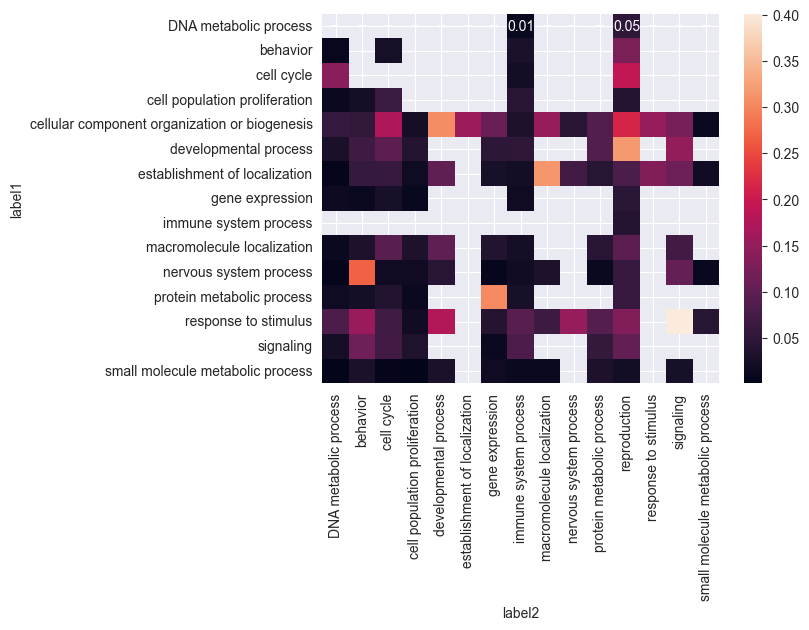

In [45]:
import seaborn as sns

def plot_matrix(filtered: pd.DataFrame, aspect: str):
    pivoted = by_aspect(filtered, aspect).pivot(index="label1", columns="label2", values="proportion_subjects_in_common")
    ax = sns.heatmap(pivoted, annot=True, fmt=".2f")
    # ax.get_figure().savefig(f"output/{aspect}-heatmap.png", bbox_inches="tight"

plot_matrix(filtered, "biological_process")

In [52]:
from collections import defaultdict

coassoc_map = defaultdict(list)
def all_coassocs():
    for ribbon, taxa in ribbons.items():
        for taxon in taxa:
            pair = (ribbon, taxon)
            if pair not in coassoc_map:
                coassocs = fetch_matrix(taxon, ribbon)
                coassoc_map[pair] = coassocs

In [53]:
all_coassocs()

defaultdict(list,
            {('goslim_agr',
              'NCBITaxon:9606'): [PairwiseCoAssociation(object1='GO:0000003', object2='GO:0000003', object1_label=None, object2_label=None, number_subjects_in_common=1472, proportion_subjects_in_common=1.0, number_subjects_in_union=1472, number_subject_unique_to_entity1=0, number_subject_unique_to_entity2=0, subjects_in_common=[], associations_for_subjects_in_common=[]), PairwiseCoAssociation(object1='GO:0002376', object2='GO:0000003', object1_label=None, object2_label=None, number_subjects_in_common=201, proportion_subjects_in_common=0.055755894590846046, number_subjects_in_union=3605, number_subject_unique_to_entity1=2133, number_subject_unique_to_entity2=1271, subjects_in_common=[], associations_for_subjects_in_common=[]), PairwiseCoAssociation(object1='GO:0002376', object2='GO:0002376', object1_label=None, object2_label=None, number_subjects_in_common=2334, proportion_subjects_in_common=1.0, number_subjects_in_union=2334, number_subject

In [59]:
df = pd.DataFrame()
for pair, coassocs in coassoc_map.items():
    coassoc_df = coassoc_to_df(coassocs)
    filtered = coassoc_df.query("object1 != object2")
    df["ribbon"] = pair[0]
    df["taxon"] = pair[1]
    df = pd.concat([df, filtered])

In [60]:
df

,ribbon,taxon,object1,object2,number_subjects_in_common,proportion_subjects_in_common,number_subjects_in_union,number_subject_unique_to_entity1,number_subject_unique_to_entity2,label1,label2,aspect1,aspect2
1,goslim_flybase_ribbon,NCBITaxon:7227,GO:0002376,GO:0000003,201.0,0.055756,3605.0,2133.0,1271.0,immune system process,reproduction,biological_process,biological_process
3,goslim_flybase_ribbon,NCBITaxon:7227,GO:0003677,GO:0000003,311.0,0.081649,3809.0,2337.0,1161.0,DNA binding,reproduction,molecular_function,biological_process
4,goslim_flybase_ribbon,NCBITaxon:7227,GO:0003677,GO:0002376,276.0,0.058649,4706.0,2372.0,2058.0,DNA binding,immune system process,molecular_function,biological_process
6,goslim_flybase_ribbon,NCBITaxon:7227,GO:0003700,GO:0000003,144.0,0.051010,2823.0,1351.0,1328.0,DNA-binding transcription factor activity,reproduction,molecular_function,biological_process
7,goslim_flybase_ribbon,NCBITaxon:7227,GO:0003700,GO:0002376,124.0,0.033468,3705.0,1371.0,2210.0,DNA-binding transcription factor activity,immune system process,molecular_function,biological_process
...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,NaN,NaN,GO:0140110,GO:0050896,155.0,0.048152,3219.0,581.0,2483.0,transcription regulator activity,response to stimulus,molecular_function,biological_process
985,NaN,NaN,GO:0140110,GO:0051234,11.0,0.004086,2692.0,725.0,1956.0,transcription regulator activity,establishment of localization,molecular_function,biological_process
986,NaN,NaN,GO:0140110,GO:0071840,193.0,0.052008,3711.0,543.0,2975.0,transcription regulator activity,cellular component organization or biogenesis,molecular_function,biological_process
987,NaN,NaN,GO:0140110,GO:0071944,14.0,0.005571,2513.0,722.0,1777.0,transcription regulator activity,cell periphery,molecular_function,cellular_component


In [62]:
by_aspect(df, "molecular_function").sort_values(by="proportion_subjects_in_common", ascending=False)

,ribbon,taxon,object1,object2,number_subjects_in_common,proportion_subjects_in_common,number_subjects_in_union,number_subject_unique_to_entity1,number_subject_unique_to_entity2,label1,label2,aspect1,aspect2
1170,goslim_flybase_ribbon,NCBITaxon:7227,GO:0046872,GO:0036094,4347.0,0.679113,6401.0,0.0,2054.0,metal ion binding,small molecule binding,molecular_function,molecular_function
1170,goslim_flybase_ribbon,NCBITaxon:7227,GO:0046872,GO:0036094,3687.0,0.649463,5677.0,0.0,1990.0,metal ion binding,small molecule binding,molecular_function,molecular_function
8,goslim_flybase_ribbon,NCBITaxon:7227,GO:0003700,GO:0003677,1484.0,0.558105,2659.0,11.0,1164.0,DNA-binding transcription factor activity,DNA binding,molecular_function,molecular_function
8,goslim_flybase_ribbon,NCBITaxon:7227,GO:0003700,GO:0003677,1323.0,0.551250,2400.0,22.0,1055.0,DNA-binding transcription factor activity,DNA binding,molecular_function,molecular_function
1170,goslim_flybase_ribbon,NCBITaxon:7227,GO:0046872,GO:0036094,968.0,0.540179,1792.0,0.0,824.0,metal ion binding,small molecule binding,molecular_function,molecular_function
...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,goslim_flybase_ribbon,NCBITaxon:7227,GO:0038023,GO:0008289,0.0,0.000000,169.0,16.0,153.0,signaling receptor activity,lipid binding,molecular_function,molecular_function
972,goslim_flybase_ribbon,NCBITaxon:7227,GO:0038023,GO:0008134,0.0,0.000000,92.0,16.0,76.0,signaling receptor activity,transcription factor binding,molecular_function,molecular_function
971,goslim_flybase_ribbon,NCBITaxon:7227,GO:0038023,GO:0008092,0.0,0.000000,137.0,16.0,121.0,signaling receptor activity,cytoskeletal protein binding,molecular_function,molecular_function
954,goslim_flybase_ribbon,NCBITaxon:7227,GO:0038023,GO:0005215,0.0,0.000000,474.0,16.0,458.0,signaling receptor activity,transporter activity,molecular_function,molecular_function


In [63]:
by_aspect(df, "biological_process").sort_values(by="proportion_subjects_in_common", ascending=False)


,ribbon,taxon,object1,object2,number_subjects_in_common,proportion_subjects_in_common,number_subjects_in_union,number_subject_unique_to_entity1,number_subject_unique_to_entity2,label1,label2,aspect1,aspect2
856,goslim_flybase_ribbon,NCBITaxon:7227,GO:0032502,GO:0030154,4001.0,0.647935,6175.0,2174.0,0.0,developmental process,cell differentiation,biological_process,biological_process
856,goslim_flybase_ribbon,NCBITaxon:7227,GO:0032502,GO:0030154,3756.0,0.635641,5909.0,2153.0,0.0,developmental process,cell differentiation,biological_process,biological_process
1259,goslim_flybase_ribbon,NCBITaxon:7227,GO:0050896,GO:0023052,5698.0,0.579183,9838.0,3977.0,163.0,response to stimulus,signaling,biological_process,biological_process
1259,goslim_flybase_ribbon,NCBITaxon:7227,GO:0050896,GO:0023052,4987.0,0.576399,8652.0,3473.0,192.0,response to stimulus,signaling,biological_process,biological_process
856,goslim_flybase_ribbon,NCBITaxon:7227,GO:0032502,GO:0030154,116.0,0.552381,210.0,94.0,0.0,developmental process,cell differentiation,biological_process,biological_process
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,goslim_flybase_ribbon,NCBITaxon:7227,GO:0008283,GO:0002376,0.0,NaN,0.0,0.0,0.0,cell population proliferation,immune system process,biological_process,biological_process
402,goslim_flybase_ribbon,NCBITaxon:7227,GO:0008283,GO:0007610,0.0,NaN,0.0,0.0,0.0,cell population proliferation,behavior,biological_process,biological_process
1177,goslim_flybase_ribbon,NCBITaxon:7227,GO:0050877,GO:0002376,0.0,NaN,0.0,0.0,0.0,nervous system process,immune system process,biological_process,biological_process
1200,goslim_flybase_ribbon,NCBITaxon:7227,GO:0050877,GO:0007610,0.0,NaN,0.0,0.0,0.0,nervous system process,behavior,biological_process,biological_process


In [64]:
by_aspect(df, "cellular_component").sort_values(by="proportion_subjects_in_common", ascending=False)

,ribbon,taxon,object1,object2,number_subjects_in_common,proportion_subjects_in_common,number_subjects_in_union,number_subject_unique_to_entity1,number_subject_unique_to_entity2,label1,label2,aspect1,aspect2
1116,goslim_flybase_ribbon,NCBITaxon:7227,GO:0045202,GO:0030054,1644.0,0.717904,2290.0,0.0,646.0,synapse,cell junction,cellular_component,cellular_component
656,NaN,NaN,GO:0045202,GO:0030054,336.0,0.697095,482.0,0.0,146.0,synapse,cell junction,cellular_component,cellular_component
1116,goslim_flybase_ribbon,NCBITaxon:7227,GO:0045202,GO:0030054,1484.0,0.662796,2239.0,0.0,755.0,synapse,cell junction,cellular_component,cellular_component
793,goslim_flybase_ribbon,NCBITaxon:7227,GO:0031410,GO:0005768,200.0,0.623053,321.0,121.0,0.0,cytoplasmic vesicle,endosome,cellular_component,cellular_component
793,goslim_flybase_ribbon,NCBITaxon:7227,GO:0031410,GO:0005768,1030.0,0.473346,2176.0,1146.0,0.0,cytoplasmic vesicle,endosome,cellular_component,cellular_component
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,goslim_flybase_ribbon,NCBITaxon:7227,GO:0045202,GO:0005576,0.0,0.000000,131.0,0.0,131.0,synapse,extracellular region,cellular_component,cellular_component
1070,goslim_flybase_ribbon,NCBITaxon:7227,GO:0042995,GO:0030054,0.0,0.000000,136.0,136.0,0.0,cell projection,cell junction,cellular_component,cellular_component
100,goslim_flybase_ribbon,NCBITaxon:7227,GO:0005768,GO:0005576,0.0,0.000000,331.0,200.0,131.0,endosome,extracellular region,cellular_component,cellular_component
1098,goslim_flybase_ribbon,NCBITaxon:7227,GO:0045202,GO:0005829,0.0,0.000000,1298.0,0.0,1298.0,synapse,cytosol,cellular_component,cellular_component
